# 4. Clasificación de noticias falsas
José Luis Aguilera Luzania

## Contenido

## 4.1 Introducción

**¿Qué es la detección de noticias falsas? (*Fake News*)**
La detección de noticias falsas (Fake News) es la tarea de evaluar la veracidad de las afirmaciones en las noticias. Este es un problema crítico en el Procesamiento del Lenguaje Natural (PLN) porque tanto en medios de noticias tradicionales como en medios digitales las Fake News generan un gran impacto social y político en cada individuo. Por ejemplo, la exposición a las Fake News puede generar actitudes de ineficacia, alienación y cinismo hacia ciertos candidatos políticos (Balmas, 2014).

**Objetivo de la libreta**
El objetivo de esta libreta es

## 4.2 Procesamiento de los datos

**Librerías**
Manipulación de datos:
- `pandas`: Librería para manipular los datos de forma tabular.
- `cmd`: Librería para controlar el formato de impresión en la consola.

Procesamiento del lenguaje natural:
- `nltk`: Librería para utilizar técnicas de procesamiento del lenguaje natural.

Representación de los datos:
- `wordcloud`: Librería para generar una nube de palabras y guardarla como imagen *.png*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

**Datos adicionales para la librería `nltk`**

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoseLuis_AL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoseLuis_AL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Conjunto de datos**

El conjunto de datos se encuentra en el archivo *datos.csv*.

In [3]:
#df_datos = pd.read_csv('Datos/datos.csv')
df_datos = pd.read_csv('Datos/datos_procesados.csv', encoding='utf-8')

**Información de los datos**

In [4]:
# Información del dataframe.
print(f'Noticias, Columnas: {df_datos.shape}')
print(f'Columnas: {list(df_datos.columns)}')
print('Noticias verdaderas: {}'.format(df_datos.groupby('categoria').size()[0]))
print('Noticias falsas: {}'    .format(df_datos.groupby('categoria').size()[1]))

# Primeros elementos del dataframe.
df_datos.head()

Noticias, Columnas: (3974, 5)
Columnas: ['categoria', 'tema', 'fuente', 'encabezado', 'texto']
Noticias verdaderas: 1928
Noticias falsas: 2046


,categoria,tema,fuente,encabezado,texto
0,1,ciencia,el pais,la nasa recupera el contacto con un satelite d...,la nasa recupera el contacto con un satelite d...
1,1,economía,el financiero,amlo aceleraria el consumo y el crecimiento ec...,amlo aceleraria el consumo y el crecimiento ec...
2,0,deportes,actualidadpanamericana com,companero de james se calvea y le juega pesada...,al borde de un colapso nervioso quedo el habil...
3,0,política,actualidadpanamericana com,dian gravara este ano a los ninos que recojan ...,mediante pupitrazo de ultimo minuto anoche el ...
4,0,política,actualidadpanamericana com,uribe asegura que insulto 358 guerrilleros,muy temprano esta manana el expresidente y aho...


**Datos necesarios**

In [5]:
X = df_datos['texto']
y = df_datos['categoria']

**Palabras vacías o *stopwords* en español**

Las *stopwords* o palabras vacías son aquellas que carecen de sentido de manera individual o sin una palabra clave o *keyword*. Algunos ejemplos son: el, la, ellos, ustedes, para, ser, etc.

Se utilizan las *stopwords* proporcionadas por la librería `nltk` en conjunto con las obtenidas del repositorio "stopwords-es" del usuario [genediazjr](https://github.com/stopwords-iso/stopwords-es)

In [6]:
# Obtener las stopwords.
stopwords_spanish_nltk = stopwords.words('spanish')
stopwords_spanish_json = list(pd.read_json('Datos/stopwords-es.json')[0])

# Se concatenan las stopwords, se crea un set para eliminar repetidos y sé genera una lista.
stopwords_spanish = list(set(stopwords_spanish_nltk+stopwords_spanish_json))

# Se agrega la stopword 'NUMBER', debido a que no aporta nada a los datos para el análisis.
stopwords_spanish.append('number')

**Stemmer**

In [7]:
snowball_stemmer = SnowballStemmer('spanish')

**Preparación de los datos**

In [8]:
def procesar_texto(texto):
    """
    Input:
        texto: una cadena de texto.

    Output:
        texto: una cadena de texto formada solo por las palabras del texto original, sin acentos, caracteres especiales o espacios extra.
    """
    # Solo las palabras
    texto_p = re.sub('[^a-zA-Z]', ' ', texto)

    # minúsculas.
    texto_p = texto_p.lower()

    # Tokenizar.
    texto_p = texto_p.split()

    # Lematizar las palabras y remover las stopwords.
    texto_p = [snowball_stemmer.stem(palabra) for palabra in texto_p if not palabra in stopwords_spanish]

    # Unir todos los tokens.
    texto_p = ' '.join(texto_p)

    return texto_p

In [9]:
X = X.apply(procesar_texto)

In [10]:
X = X.values
y = y.values

**Vectorización de los datos**

In [11]:
vectorizer = TfidfVectorizer(lowercase=False)

In [12]:
X = vectorizer.fit_transform(X).toarray()

**Separación de los datos**

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2021)

**Métricas**

In [14]:
font_size_title = 20
font_size_label = 15
cf_matrix_fig_width = 8
cf_matrix_fig_height = 8
clf_report_fig_width = 13
clf_report_fig_height = 8

## 4.3 Multinomial Naive Bayes

**¿Qué es?**

Clasificador, entrenamiento y predición

In [15]:
# Modelo.
classifierNB = MultinomialNB(alpha=0.5)

# Entrenamiento.
classifierNB.fit(X_train, Y_train)

# Predicción.
y_pred_NB = classifierNB.predict(X_test)

**Reporte de clasificación**

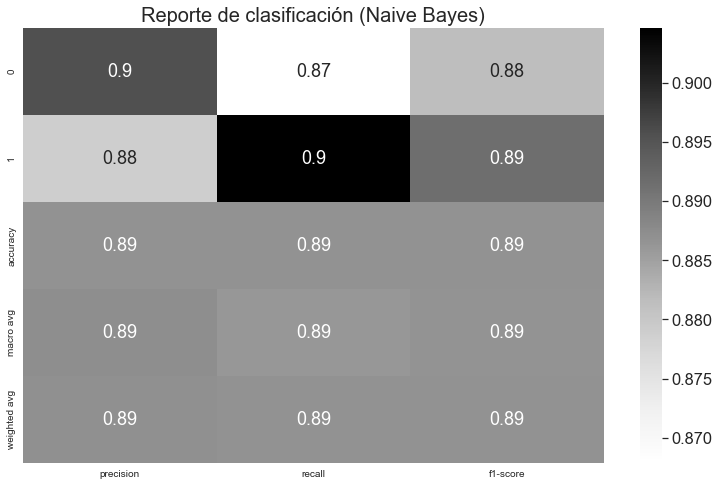

In [16]:
# Reporte.
clf_report_naive_bayes = classification_report(Y_test, y_pred_NB, output_dict=True)

# Crear la gráfica.
plt.subplots(figsize=(clf_report_fig_width, clf_report_fig_height))
sns.set(font_scale=1.5)
ax = sns.heatmap(pd.DataFrame(clf_report_naive_bayes).iloc[:-1, :].T, annot=True, cmap='Greys')

# Definir los datos de la gráfica.
ax.set_title('Reporte de clasificación (Naive Bayes)', fontsize=font_size_title)

# Guardar la imagen.
plt.savefig('Plots/Metrics/clf_report_naive_bayes.png')

# Mostrar.
plt.show()

**Matriz de confusión**

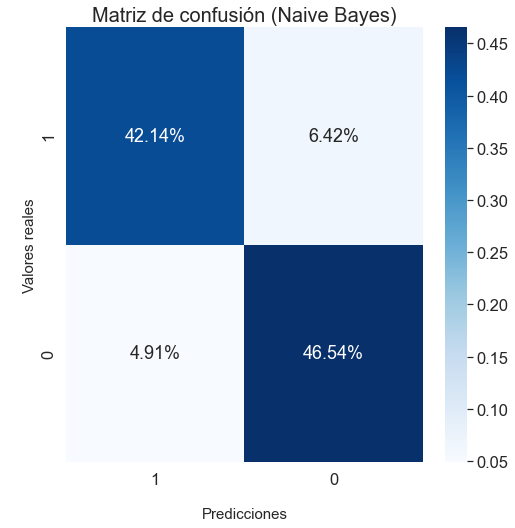

In [17]:
# Crear la matriz de confusión.
cf_matrix_NB = confusion_matrix(y_pred=y_pred_NB,y_true=Y_test)

# Crear la gráfica.
plt.subplots(figsize=(cf_matrix_fig_width, cf_matrix_fig_height))
ax = sns.heatmap(cf_matrix_NB/np.sum(cf_matrix_NB), annot=True, fmt='.2%', cmap='Blues')

# Definir los datos de la gráfica.
ax.set_title('Matriz de confusión (Naive Bayes)', fontsize=font_size_title)
ax.set_xlabel('\nPredicciones', fontsize=font_size_label)
ax.set_ylabel('\nValores reales', fontsize=font_size_label)

# Ticket labels.
ax.xaxis.set_ticklabels(['1','0'])
ax.yaxis.set_ticklabels(['1','0'])

# Guardar la imagen.
plt.savefig('Plots/Metrics/cf_matrix_nive_bayes.png')

# Mostrar.
plt.show()

## 4.4 Regresión Logística

**¿Qué es?**

**Clasificador, entrenamiento y predicción**

In [18]:
# Modelo.
classifierRL = LogisticRegression(max_iter=5000)

# Entrenamiento.
classifierRL.fit(X_train, Y_train)

# Predicción.
y_pred_reg = classifierRL.predict(X_test)

**Reporte de clasificación**

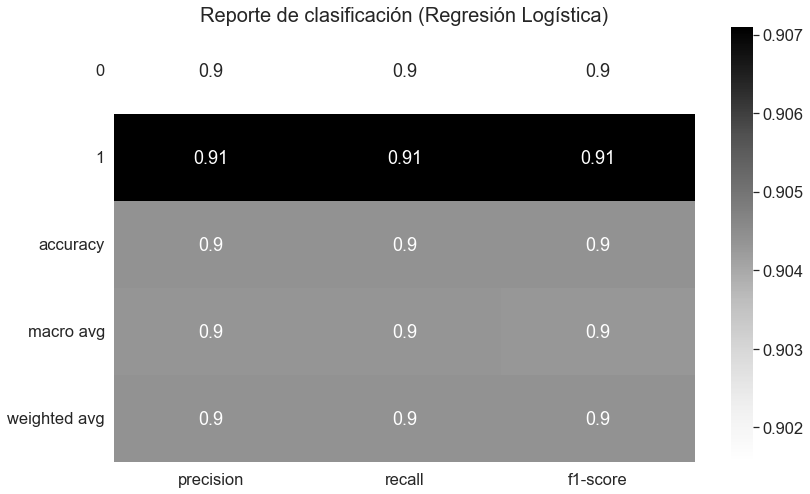

In [19]:
# Reporte.
clf_report_reg = classification_report(Y_test, y_pred_reg, output_dict=True)

# Crear la gráfica.
plt.subplots(figsize=(clf_report_fig_width, clf_report_fig_height))
sns.set(font_scale=1.5)
ax = sns.heatmap(pd.DataFrame(clf_report_reg).iloc[:-1, :].T, annot=True, cmap='Greys')

# Definir los datos de la gráfica.
ax.set_title('Reporte de clasificación (Regresión Logística)', fontsize=font_size_title)

# Guardar la imagen.
plt.savefig('Plots/Metrics/clf_report_regression.png')

# Mostrar.
plt.show()

**Matriz de confusión**

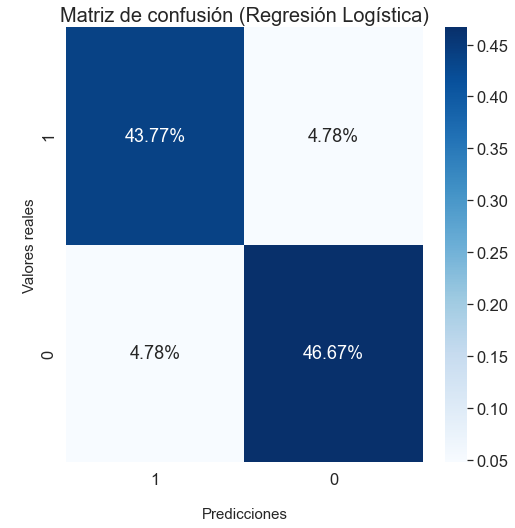

In [20]:
# Crear la matriz de confusión.
cf_matrix_reg = confusion_matrix(y_pred=y_pred_reg,y_true=Y_test)

# Crear la gráfica.
plt.subplots(figsize=(cf_matrix_fig_width, cf_matrix_fig_height))
ax = sns.heatmap(cf_matrix_reg/np.sum(cf_matrix_reg), annot=True, fmt='.2%', cmap='Blues')

# Definir los datos de la gráfica.
ax.set_title('Matriz de confusión (Regresión Logística)', fontsize=font_size_title)
ax.set_xlabel('\nPredicciones', fontsize=font_size_label)
ax.set_ylabel('\nValores reales', fontsize=font_size_label)

# Ticket labels.
ax.xaxis.set_ticklabels(['1','0'])
ax.yaxis.set_ticklabels(['1','0'])

# Guardar la imagen.
plt.savefig('Plots/Metrics/cf_matrix_regression.png')

# Mostrar.
plt.show()

## 4.5 LSTM

**¿Qué es?**


**Datos**

In [21]:
df_datos.head()

,categoria,tema,fuente,encabezado,texto
0,1,ciencia,el pais,la nasa recupera el contacto con un satelite d...,la nasa recupera el contacto con un satelite d...
1,1,economía,el financiero,amlo aceleraria el consumo y el crecimiento ec...,amlo aceleraria el consumo y el crecimiento ec...
2,0,deportes,actualidadpanamericana com,companero de james se calvea y le juega pesada...,al borde de un colapso nervioso quedo el habil...
3,0,política,actualidadpanamericana com,dian gravara este ano a los ninos que recojan ...,mediante pupitrazo de ultimo minuto anoche el ...
4,0,política,actualidadpanamericana com,uribe asegura que insulto 358 guerrilleros,muy temprano esta manana el expresidente y aho...


**Crear los embeddings de las palabras**

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [51]:
# Tokeniza text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_datos['texto'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

74486

In [64]:
# Padding data
sequences = tokenizer.texts_to_sequences(df_datos['texto'])
padded_seq = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

**Embedding Matrix**

In [65]:
word_embeddings_spanish_path = 'Datos/SBW-vectors-300-min5.txt'

In [66]:
embedding_index = {}
with open(word_embeddings_spanish_path, 'r', encoding="utf8") as file:
    file.readline()
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [67]:
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**Separación de los datos**

In [68]:
x_train, x_test, y_train, y_test = train_test_split(padded_seq, df_datos['categoria'], test_size=0.2, stratify=df_datos['categoria'], random_state=2021)

**Modelo**

In [69]:
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential

In [70]:
model = Sequential([
    Embedding(vocab_size+1, 300, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 300)         22346100  
                                                                 
 dropout_18 (Dropout)        (None, None, 300)         0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               219648    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 22,599,029
Trainable params: 252,929
Non

**Entrenamiento**

In [71]:
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/40
100/100 [==============================] - 7s 51ms/step - loss: 0.5775 - acc: 0.7273 - val_loss: 0.5247 - val_acc: 0.7648
Epoch 2/40
100/100 [==============================] - 5s 47ms/step - loss: 0.4944 - acc: 0.7732 - val_loss: 0.4385 - val_acc: 0.8176
Epoch 3/40
100/100 [==============================] - 5s 45ms/step - loss: 0.5394 - acc: 0.7458 - val_loss: 0.5476 - val_acc: 0.7346
Epoch 4/40
100/100 [==============================] - 5s 45ms/step - loss: 0.5320 - acc: 0.7427 - val_loss: 0.4839 - val_acc: 0.7660
Epoch 5/40
100/100 [==============================] - 5s 45ms/step - loss: 0.5128 - acc: 0.7553 - val_loss: 0.5048 - val_acc: 0.7572
Epoch 6/40
100/100 [==============================] - 4s 45ms/step - loss: 0.5082 - acc: 0.7518 - val_loss: 0.4588 - val_acc: 0.7887
Epoch 7/40
100/100 [==============================] - 5s 46ms/step - loss: 0.5069 - acc: 0.7528 - val_loss: 0.4905 - val_acc: 0.7686
Epoch 8/40
100/100 [==============================] - 5s 45ms/step - 

**Reporte de clasificación**

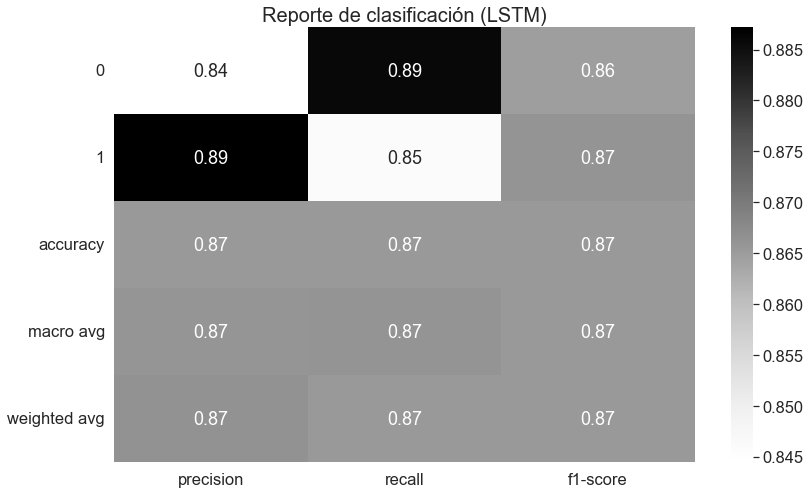

In [72]:
# Predicciones.
LSTM_pred = (model.predict(x_test) >= 0.5).astype(int)

# Reporte.
clf_report_lstm = classification_report(y_test, LSTM_pred, output_dict=True)

# Crear la gráfica.
plt.subplots(figsize=(clf_report_fig_width, clf_report_fig_height))
sns.set(font_scale=1.5)
ax = sns.heatmap(pd.DataFrame(clf_report_lstm).iloc[:-1, :].T, annot=True, cmap='Greys')

# Definir los datos de la gráfica.
ax.set_title('Reporte de clasificación (LSTM)', fontsize=font_size_title)

# Guardar la imagen.
plt.savefig('Plots/Metrics/clf_report_lstm.png')

# Mostrar.
plt.show()

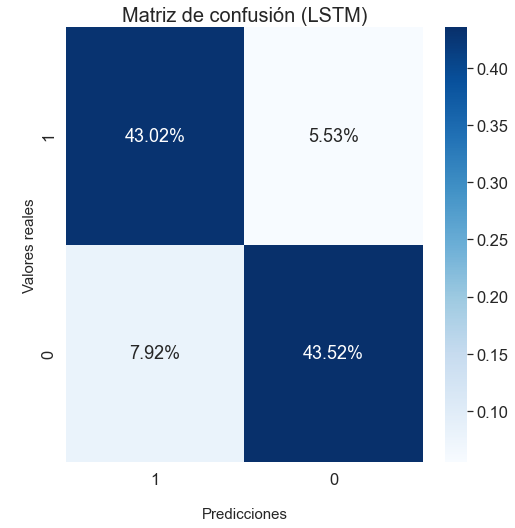

In [73]:
# Crear la matriz de confusión.
cf_matrix_LSTM = confusion_matrix(y_pred=LSTM_pred,y_true=y_test)

# Crear la gráfica.
plt.subplots(figsize=(cf_matrix_fig_width, cf_matrix_fig_height))
ax = sns.heatmap(cf_matrix_LSTM/np.sum(cf_matrix_LSTM), annot=True, fmt='.2%', cmap='Blues')

# Definir los datos de la gráfica.
ax.set_title('Matriz de confusión (LSTM)', fontsize=font_size_title)
ax.set_xlabel('\nPredicciones', fontsize=font_size_label)
ax.set_ylabel('\nValores reales', fontsize=font_size_label)

# Ticket labels.
ax.xaxis.set_ticklabels(['1','0'])
ax.yaxis.set_ticklabels(['1','0'])

# Guardar la imagen.
plt.savefig('Plots/Metrics/cf_matrix_lstm.png')

# Mostrar.
plt.show()

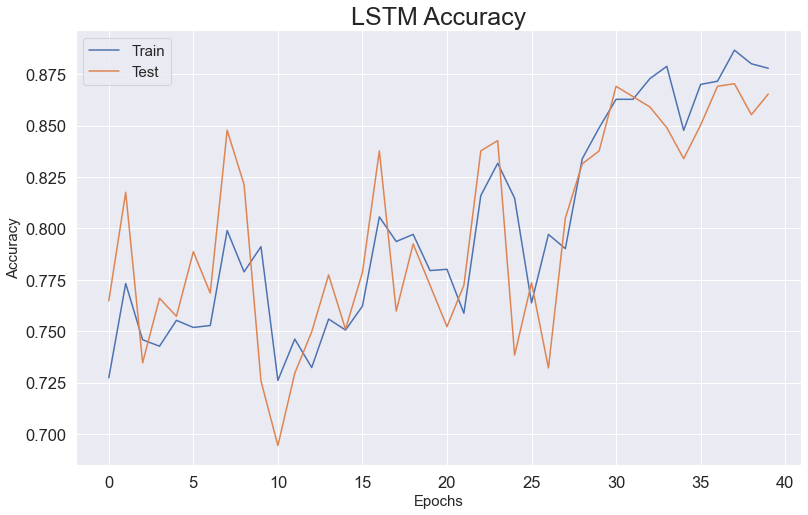

In [74]:
# Crear la gráfica.
_, ax = plt.subplots(figsize=(13, 8))

# Configuración de la gráfica.
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('LSTM Accuracy', fontsize=25)
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.legend(['Train', 'Test'], fontsize=15)


# Guardar gráfica.
plt.savefig('Plots/Metrics/fig_accuracy_lstm.png')

# Mostrar gráfica.
plt.show()

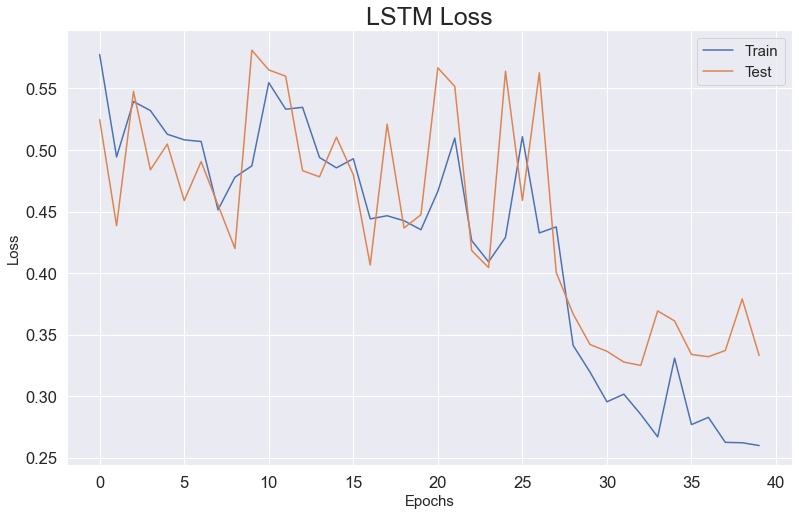

In [75]:
# Crear la gráfica.
_, ax = plt.subplots(figsize=(13, 8))

# Configuración de la gráfica.
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('LSTM Loss', fontsize=25)
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.legend(['Train', 'Test'], fontsize=15)

# Guardar gráfica.
plt.savefig('Plots/Metrics/fig_loss_lstm.png')

# Mostrar gráfica.
plt.show()

## 4.6 Conclusiones

Texto Texto Texto Texto Texto Texto Texto Texto